In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Blocs creation

In [2]:
from sklearn.base import BaseEstimator, TransformerMixin

## Standardisation

In [3]:
from sklearn.preprocessing import StandardScaler

class Standselector(BaseEstimator, TransformerMixin):
    
    def __init__(self, column):
        self.scaler = StandardScaler()
        self.column = column
    
    def fit(self, X, y=None):
        Xasm = np.concatenate(X[self.column].tolist())
        self.scaler.fit(Xasm)
        return self
        
    
    def transform(self, X, y=None):
        toreturn = []
        for color in X[self.column]:
            toreturn.append(self.scaler.transform(color))
        return toreturn

colorstand = Standselector('kp')
#colorstand.fit(dftrain)
#color_std = colorstand.transform(X_train)
#color_std

## Kmeans

In [4]:
from sklearn.cluster import KMeans
import inspect

class KmeansPlus(BaseEstimator, TransformerMixin):
    
    def __init__(self, n_clusters=50, verbose=0, random_state=0, letter='c'):
        args, _, _, values = inspect.getargvalues(inspect.currentframe())
        values.pop("self")
        
        for arg, val in values.items():
            setattr(self, arg, val)
        
    
    def fit(self, X, y=None):
        self.kmeans = KMeans(n_clusters=self.n_clusters,
                             verbose=self.verbose,
                             random_state=self.random_state)
        Xasm = np.concatenate(X)
        
        idx = np.random.randint(Xasm.shape[0], size=10000)
        Xsample = Xasm[idx,:]
        
        self.kmeans.fit(Xsample)
        return self
        
    
    def transform(self, X, y=None):
        toreturn = []
        for color in X:
            color = self.kmeans.predict(color)
            toappend = ' '.join(['{}{}'.format(self.letter, x) for x in color])
            toreturn.append(toappend)
        return toreturn

colorkmeans = KmeansPlus()
#colorkmeans.fit(color_std)
#bagofcolors = colorkmeans.transform(color_std)
#bagofcolors

## countvectorizer

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

class CvectPlus(BaseEstimator, TransformerMixin):
    
    def __init__(self, **kwargs):
        self.params = {'max_df':1.0, 'min_df':1, 'max_features':None, 'analyzer':'word', **kwargs}
        self.cvect = CountVectorizer(**self.params)
    
    def fit(self, X, y=None):
        self.cvect.fit(X)
        self.vocabulary_ = self.cvect.vocabulary_
        return self
        
    
    def transform(self, X, y=None):
        return self.cvect.transform(X)
    
    def get_params(self, deep=True):
        return self.params
    
    def set_params(self, **params):
        self.params = {**self.params, **params}
        self.cvect.set_params(**params)
        return self
    
    def get_feature_names(self):
        return self.cvect.get_feature_names()
    

colorcvect = CvectPlus()
#colorcvect.fit(bagofcolors)
#colorcvect.transform(bagofcolors)

## Pipeline creation

In [6]:
from sklearn.pipeline import Pipeline
#descriptors pipe
pipekp = [('stdkp', Standselector('kp')), ('kmkp',KmeansPlus(letter='kp', n_clusters=200)), ('cvectkp', CvectPlus())]
pipecolor = [('stdcolor', Standselector('colors')), ('kmcol',KmeansPlus(letter='c', n_clusters=50)), ('cvectcol', CvectPlus())]
kppipe = Pipeline(pipekp)
colorpipe = Pipeline(pipecolor)

In [7]:
from sklearn.pipeline import FeatureUnion
features = [('kp', kppipe), ('color', colorpipe)]
featureasm = FeatureUnion(features)


## Plotting feature

In [8]:
# Graph construction
def plot_clust_tsne(X_embedded, label):
    colors = label
    coords = X_embedded
    fig, ax = plt.subplots(figsize=(15,10))
    plt.scatter(x=coords[:,0], y=coords[:,1], c=colors)
    plt.colorbar()
    plt.title('T-SNE - Sift and color features - 5 breeds')
    plt.xlabel('First Component')
    plt.ylabel('Second Component')
    
    
    plt.show()

# T-SNE - no pre-treatment

In [9]:
trainset_notr = pd.read_csv('trainset_notr.csv', index_col=0, dtype={'breeds':'int32'})
#trainset_notr.head()
testset_notr = pd.read_csv('testset_notr.csv', index_col=0, dtype={'breeds':'int32'})

In [10]:
trainsaved_notr = np.load('Z2 - trainset_notr.npz')
kptrain_notr = trainsaved_notr['kptrain']
colortrain_notr = trainsaved_notr['colortrain']

In [11]:
testsaved_notr = np.load('Z2 - testset_notr.npz')
kptest_notr = testsaved_notr['kptest']
colortest_notr = testsaved_notr['colortest']

In [12]:
dtrain_notr = {'kp':kptrain_notr.tolist(),
               'colors':colortrain_notr.tolist(),
               'breeds':trainset_notr['breeds'].tolist(),
               'filepath':trainset_notr['paths'].tolist()}
dftrain_notr = pd.DataFrame(data=dtrain_notr)
dftrain_notr['colors'] = dftrain_notr['colors'].apply(lambda x: np.array(x))
dftrain_notr['kp'] = dftrain_notr['kp'].apply(lambda x: np.array(x))

dtest_notr = {'kp':kptest_notr.tolist(),
              'colors':colortest_notr.tolist(),
              'breeds':testset_notr['breeds'].tolist(),
              'filepath':testset_notr['paths'].tolist()}
dftest_notr = pd.DataFrame(data=dtest_notr)
dftrain_notr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 4 columns):
breeds      500 non-null int64
colors      500 non-null object
filepath    500 non-null object
kp          500 non-null object
dtypes: int64(1), object(3)
memory usage: 15.7+ KB


In [13]:
dftrain_notr = dftrain_notr[np.logical_not(dftrain_notr['kp'].isnull())]
dftest_notr = dftest_notr[np.logical_not(dftest_notr['kp'].isnull())]

In [14]:
dftrain_notr.head()

,breeds,colors,filepath,kp
0,0,"[[244.6735076904297, 239.04693603515625, 204.8...",train5/n02088364-beagle/n02088364_10362.jpg,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0,..."
1,0,"[[137.01922607421875, 102.39904022216797, 75.4...",train5/n02088364-beagle/n02088364_10731.jpg,"[[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 72.0..."
2,0,"[[206.76788330078125, 177.69076538085938, 145....",train5/n02088364-beagle/n02088364_11130.jpg,"[[17.0, 30.0, 7.0, 0.0, 0.0, 0.0, 0.0, 1.0, 14..."
3,0,"[[137.44252014160156, 179.9897003173828, 198.6...",train5/n02088364-beagle/n02088364_11231.jpg,"[[76.0, 7.0, 0.0, 0.0, 1.0, 34.0, 54.0, 46.0, ..."
4,0,"[[251.80032348632812, 243.03160095214844, 177....",train5/n02088364-beagle/n02088364_1128.jpg,"[[17.0, 3.0, 1.0, 11.0, 39.0, 26.0, 14.0, 30.0..."


In [15]:
X = pd.concat([dftrain_notr, dftest_notr])
X.shape

(889, 4)

In [16]:
features_notr = [('kp', kppipe), ('color', colorpipe)]
featureasm_notr = FeatureUnion(features_notr)

featureasm_notr.fit(X)
XTrans_notr = featureasm_notr.transform(X)

In [17]:
XTrans_notr.shape

(889, 250)

In [18]:
scaler = StandardScaler()
Xscaled_notr = scaler.fit_transform(XTrans_notr.toarray())

/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [19]:
from sklearn.manifold import TSNE
X_embedded_notr = TSNE(n_components=2, n_iter=1500).fit_transform(Xscaled_notr)
X_embedded_notr.shape

(889, 2)

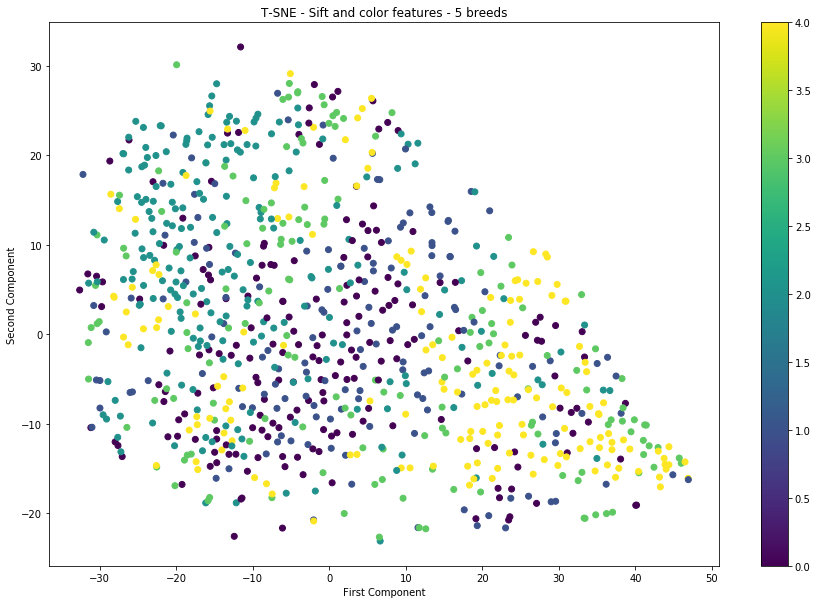

In [20]:
plot_clust_tsne(X_embedded_notr, X['breeds'])

In [21]:
from sklearn.metrics import silhouette_score
silhouette_score(X_embedded_notr, X['breeds'])

-0.06244643

# T-Sne - With treatment

In [22]:
trainset = pd.read_csv('trainset.csv', index_col=0, dtype={'breeds':'int32'})
testset = pd.read_csv('testset.csv', index_col=0, dtype={'breeds':'int32'})

In [23]:
trainsaved = np.load('Z2 - trainset.npz')
trainsaved.files
kptrain = trainsaved['kptrain']
colortrain = trainsaved['colortrain']

In [24]:
testsaved = np.load('Z2 - testset.npz')
testsaved.files
kptest = testsaved['kptest']
colortest = testsaved['colortest']

In [25]:
dtrain = {'kp':kptrain.tolist(), 'colors':colortrain.tolist(), 'breeds':trainset['breeds'].tolist(), 'filepath':trainset['paths'].tolist()}
dftrain = pd.DataFrame(data=dtrain)
dftrain['colors'] = dftrain['colors'].apply(lambda x: np.array(x))
dftrain['kp'] = dftrain['kp'].apply(lambda x: np.array(x))
dtest = {'kp':kptest.tolist(), 'colors':colortest.tolist(), 'breeds':testset['breeds'].tolist(), 'filepath':testset['paths'].tolist()}
dftest = pd.DataFrame(data=dtest)
dftrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 4 columns):
breeds      500 non-null int64
colors      500 non-null object
filepath    500 non-null object
kp          497 non-null object
dtypes: int64(1), object(3)
memory usage: 15.7+ KB


In [26]:
dftrain = dftrain[np.logical_not(dftrain['kp'].isnull())]
dftest = dftest[np.logical_not(dftest['kp'].isnull())]

In [27]:
dftrain.head()

,breeds,colors,filepath,kp
0,0,"[[210.75672912597656, 184.65771484375, 81.2220...",train5/n02088364-beagle/n02088364_10362.jpg,"[[25.0, 10.0, 2.0, 0.0, 0.0, 0.0, 0.0, 4.0, 16..."
1,0,"[[160.35317993164062, 105.8562240600586, 59.38...",train5/n02088364-beagle/n02088364_10731.jpg,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 111...."
2,0,"[[232.3618927001953, 63.0051155090332, 86.2237...",train5/n02088364-beagle/n02088364_11130.jpg,"[[28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0, 155..."
3,0,"[[109.71084594726562, 145.46788024902344, 162....",train5/n02088364-beagle/n02088364_11231.jpg,"[[0.0, 1.0, 5.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0,..."
4,0,"[[179.91407775878906, 153.6008758544922, 119.3...",train5/n02088364-beagle/n02088364_1128.jpg,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 83.0..."


In [28]:
X = pd.concat([dftrain, dftest])
X.shape

(884, 4)

In [29]:
features = [('kp', kppipe), ('color', colorpipe)]
featureasm = FeatureUnion(features)
featureasm.fit(X)
XTrans = featureasm.transform(X)

In [30]:
scaler = StandardScaler()
Xscaled = scaler.fit_transform(XTrans.toarray())

/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [31]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, n_iter=1500).fit_transform(Xscaled)
X_embedded.shape

(884, 2)

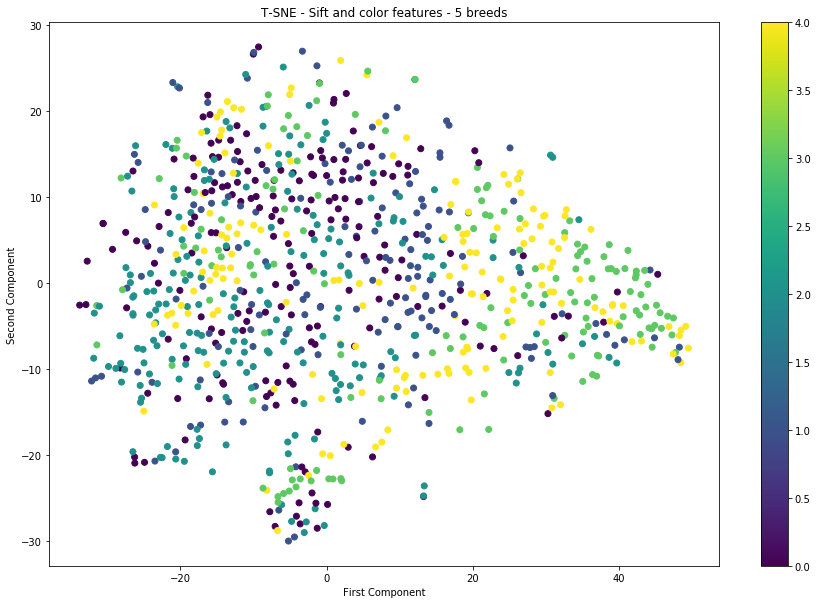

In [32]:
plot_clust_tsne(X_embedded, X['breeds'])

In [33]:
from sklearn.metrics import silhouette_score
silhouette_score(X_embedded, X['breeds'])

-0.07881895